# EMG Hand Gesture Classification

This notebook is used to explore the approaches from "A Robust, Real-Time Control Scheme for
Multifunction Myoelectric Control" (Englehart & Hudgins, 2003), while using the data provided by the paper "Latent Factors Limiting the Performance of sEMG-Interfaces" (Lobov et al., 2018), recorded using a MYO Thalmic bracelet.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import scipy
import os

### Data Preparation
This section serves to take the raw data, and reshape it/preprocess it before any real analysis being carried out.
- Data structure: dictionary of lists (keys are subject number), with lists each containing two dataframes corresponding to individual series

In [3]:
DIR = '../' # where data directories are found relative to code
exclude = [3, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 23, 27, 35] # exclude these subjects due to ADC saturation 
DIR_SJs = []
for idx in range(1, 37):
    if idx not in exclude:
        current_dir = str(idx)
        if idx < 10:
            current_dir = '0' + current_dir
        DIR_SJs.append(current_dir)

In [4]:
def parse_file(DIR, DIR_SJ, series_n):
    ''' Given a file path, extracts numerical information based on text file provided. Returns dataframe'''
    filename = os.listdir(DIR + DIR_SJ)[series_n] # either the first or second series is extracted
    file = open(DIR + DIR_SJ + filename) # open the file to be analysed
    lines = file.readlines()
    columns = lines[0].split() # take the first row as the column labels for dataframe
    lines = lines[1:] # exclude first line which represents column labels
    data = np.zeros((len(lines), 10)) # prepare dataframe to be appropriate size
    for idx, line in enumerate(lines):
        line = line.split() # get entries into different elements
        # print(np.array(line).astype(np.float64))
        data[idx, :] = np.array(line).astype(np.float64) # convert to numerical and store in array
    file.close()
    for ch in range(1, 9): # interpolate channel values as to make data regularly sampled
        f = scipy.interpolate.interp1d(data[:, 0], data[:, ch], fill_value='extrapolate') # create interpolator based on regular data
        data[:, ch] = f(list(range(data.shape[0])))
    data[:, 0] = list(range(data.shape[0]))
    df = pd.DataFrame(data=data, columns=columns)
    df[['time', 'class']] = df[['time', 'class']].astype(np.int32) # convert timepoint and class columns to integer type
    return df

def extract_all_data(DIR, DIR_SJs):
    ''' Extracts dataframe from every single subject and series of actions. '''
    series_ns = [0,1] # possible series number
    all_data = {DIR_SJ:[] for DIR_SJ in DIR_SJs} # initialise dictionary to contain data to be analysed
    for DIR_SJ in DIR_SJs:
        for series_n in series_ns:
            df = parse_file(DIR, DIR_SJ, series_n) # get individual data file
            all_data[DIR_SJ].append(df) # add df to the list of that particular subject
    return all_data

def plot_channels(df):
    ''' Plots all channels in a given dataframe '''
    plt.figure()
    leg = []
    for idx in range(1, 9):
        plt.plot(df['time'], df['channel{}'.format(idx)])
        leg.append('channel{}'.format(idx))
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (V)')
    plt.ylabel('Single Subject Data')
    plt.legend(leg)
    plt.show()

In [5]:
df = parse_file(DIR, '01/', 0)
df

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class
0,0,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0
1,1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0
2,2,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0
3,3,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0
4,4,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0
...,...,...,...,...,...,...,...,...,...,...
63191,63191,0.00033,-0.00005,-0.00001,-0.00005,-0.00011,0.00000,0.00003,0.00018,0
63192,63192,0.00033,-0.00005,-0.00001,-0.00005,-0.00011,0.00000,0.00003,0.00018,0
63193,63193,0.00033,-0.00005,-0.00001,-0.00005,-0.00011,0.00000,0.00003,0.00018,0
63194,63194,0.00033,-0.00005,-0.00001,-0.00005,-0.00011,0.00000,0.00003,0.00018,0


In [6]:
# # Plot signals
# for DIR_SJ in DIR_SJs:
#     for series_n in range(2):
#         print(DIR_SJ, series_n) # determine which signals are definitely not okay to use
#         df = parse_file(DIR, DIR_SJ + '/', 0)
#         plot_channels(df)

# # # Plot class labels
# # plt.figure()
# # plt.plot(df['time'], df['class'])
# # plt.xlabel('Time (ms)')
# # plt.ylabel('Voltage (V)')
# # plt.ylabel('Single Subject Data')
# # plt.show()

# # Check that sampling rate matches expectations:
# print('Estimated Sampling Rate: ', df.shape[0]/df.loc[df.shape[0]-1, 'time'])

### Extracting windows from data
- Here, I will create a training and testing set from the first series, then evaluate the majority vote scheme on the second series

In [7]:
from sklearn.preprocessing import StandardScaler

class GestureClassifier: 

    def __init__(self, chosen_model, w=0.250, tau=0.016): # assume window length and processing time from original paper
        ''' Initialize GestureClassifier object.'''
        self.scaler = StandardScaler() # to standardize data
        self.feature_scaler = StandardScaler() # to standardize extracted features
        self.sos = scipy.signal.butter(N=3, Wn=(10, 499), btype='bandpass', output='sos', fs=1000) # to bandpass filter datas
        self.model = chosen_model # this way class can be used with multiple different classifiers
        self.w = w # window size in m
        self.tau = tau # step size in ms
        self.fs = 1000 # 1kHz sampling rate

    def preprocess(self, df):
        ''' Z-score normalizes channels and bandpasses signals between 10-500Hz (As in Englehart & Hudgins, 2003)'''
        self.scaler = self.scaler.fit(df.iloc[:, 1:-1]) # fit scaler
        df.iloc[:, 1:-1] = self.scaler.transform(df.iloc[:, 1:-1]) # standardize channels
        for idx in range(1, 9): # for each channel, apply bandpass filter
            df[['channel{}'.format(idx)]] = scipy.signal.sosfilt(self.sos, df[['channel{}'.format(idx)]])
        return df

    def zero_crossings(self, win):
        ''' Compute zero-crossing count for a given 8-channel window.'''
        zero_crossing = np.sum(np.diff(np.sign(win), axis=0).astype(bool), axis=0) # end up wit a row of zero-crossing values
        return zero_crossing

    def slope_sign_changes(self, win):
        ''' Compute slope-sign change count for a given 8-channel window.'''
        slope = np.diff(win, axis=0) # get slope estimate
        slope_sign_change = np.sum(np.diff(np.sign(slope), axis=0).astype(bool), axis=0) # end up wit a row of zero-crossing values
        return slope_sign_change

    def waveform_length(self, win):
        ''' Computes the waveform length feature for a given 8-channel window.'''
        abs_diffs = np.abs(np.diff(win, axis=0)) # compute absolute differences between each set of points for each channels
        return abs_diffs.sum(axis=0)

    def feature_extraction(self, df):
        ''' Given a specific channel of data, applies preprocessing, extracts features, and returns feature matrix '''
        df = self.preprocess(df) # apply preprocessing
        wsamp = np.around(self.w*self.fs).astype(int) # get window size in number of samples
        tausamp = np.around(self.tau*self.fs).astype(int) # get step size in number of samples
        wstart = 0 # sample where current window starts
        X = np.zeros((0, 32)) # dynamically create feature matrix
        y = np.zeros(0) # dynamically create labels vector
        while (wstart + wsamp) < df.shape[0]: # while there is still enough data to sample from
            x = np.zeros((1, 32)) # where to store features of this specific window (32) features
            win, labels = df.iloc[wstart:wstart+wsamp,1:-1], df.loc[wstart:wstart+wsamp,'class'].squeeze()
            # print(np.abs(win).mean(axis=0).shape)
            # Extract features
            x[0, 0:8] = np.abs(win).mean(axis=0) # MAV feature for each channel
            x[0, 8:16] = self.zero_crossings(win) # Zero-crossings feature for each channel
            x[0, 16:24] = self.slope_sign_changes(win) # Slope-sign changes feature for each channel
            x[0, 24:32] = self.waveform_length(win) # Waveform length feature for each channel
            X = np.vstack((X, x)) # add new row to matrix
            # Choose label for given window
            mode,_ = scipy.stats.mode(labels, axis=0, keepdims=False) # find which labels occured the most in the given window
            y = np.r_[y, mode] # append the label of the given window to the window of labels
            wstart += tausamp # take a step and extract features from next window
        # Save data in a new dataframe for processing
        fnames = ['MAV', 'ZC', 'SSC', 'WL'] # feature names
        columns = [fname+str(idx) for fname in fnames for idx in range(1, 9)] # feature columns
        columns.append('class') # add the class label for appropriate column
        data = np.hstack((X, y.reshape(-1, 1))) # add the labels column to the rest of the data, with 33 columns in total
        df_new = pd.DataFrame(data=data, columns=columns)
        return df_new

In [8]:
# Test that class works (without classifier for now)
DIR_SJ, series_n = '01/', 0
df = parse_file(DIR, DIR_SJ, series_n)
model = GestureClassifier(None) # no chosen model for now, default parameters chosen for the rest
df_new = model.feature_extraction(df)
scaler = StandardScaler().fit(df_new.iloc[:,:-1])
df_new.iloc[:,:-1] = scaler.transform(df_new.iloc[:,:-1])
df_new

,MAV1,MAV2,MAV3,MAV4,MAV5,MAV6,MAV7,MAV8,ZC1,ZC2,...,SSC8,WL1,WL2,WL3,WL4,WL5,WL6,WL7,WL8,class
0,-0.749164,-0.791942,-0.717614,-0.632217,-0.806343,-0.877406,-0.747044,-0.772284,-0.323187,0.178805,...,-0.593240,-0.716423,-0.741612,-0.690363,-0.622405,-0.822496,-0.823144,-0.749461,-0.759852,0.0
1,-0.747450,-0.780654,-0.718503,-0.628865,-0.812325,-0.877309,-0.741538,-0.775334,0.384318,0.534696,...,0.316916,-0.697785,-0.682980,-0.660427,-0.603048,-0.806526,-0.814688,-0.732925,-0.753474,0.0
2,-0.755226,-0.781791,-0.744508,-0.637917,-0.815934,-0.888855,-0.748039,-0.771809,0.384318,0.534696,...,0.013531,-0.703998,-0.686644,-0.686621,-0.616875,-0.817933,-0.825963,-0.729617,-0.759852,0.0
3,-0.760927,-0.776192,-0.755333,-0.635524,-0.810773,-0.894237,-0.748462,-0.769413,0.384318,0.534696,...,-0.441547,-0.710210,-0.690309,-0.694104,-0.627936,-0.820214,-0.828781,-0.739539,-0.766230,0.0
4,-0.751207,-0.783082,-0.767312,-0.655517,-0.801705,-0.890450,-0.755133,-0.767317,0.384318,0.178805,...,-0.441547,-0.703998,-0.734283,-0.739008,-0.644528,-0.817933,-0.828781,-0.739539,-0.766230,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3930,1.291881,0.717723,0.049751,-0.329225,-0.095073,0.266697,0.285038,0.810815,2.506831,0.178805,...,0.165224,1.799698,0.966043,-0.166492,-0.431598,0.007939,0.577782,0.487482,0.901614,0.0
3931,1.322986,1.026738,0.168630,-0.254132,-0.022706,0.411516,0.242349,0.747019,2.506831,0.178805,...,0.165224,1.799698,0.966043,-0.166492,-0.431598,0.007939,0.577782,0.487482,0.901614,0.0
3932,1.302475,0.904499,0.177648,-0.258635,-0.054957,0.401740,0.276520,0.489614,2.506831,0.178805,...,0.771994,1.995397,1.042997,0.058023,-0.367996,-0.028563,0.625701,0.537092,0.885669,0.0
3933,1.212970,0.839193,0.125074,-0.270274,-0.018337,0.497781,0.231510,0.314707,2.506831,-0.177087,...,0.923687,1.889782,0.955049,0.226410,-0.354169,0.055849,0.763820,0.467638,0.812322,0.0


### Data Visualization (PCA, LDA, Scatter Plots, etc)
This section will serve to visualize the extracted features relative to the classification tasks.

In [9]:
# Visualizing class distribution
fig = px.histogram(df_new, x='class', title='Gesture Distribution')
fig.show()

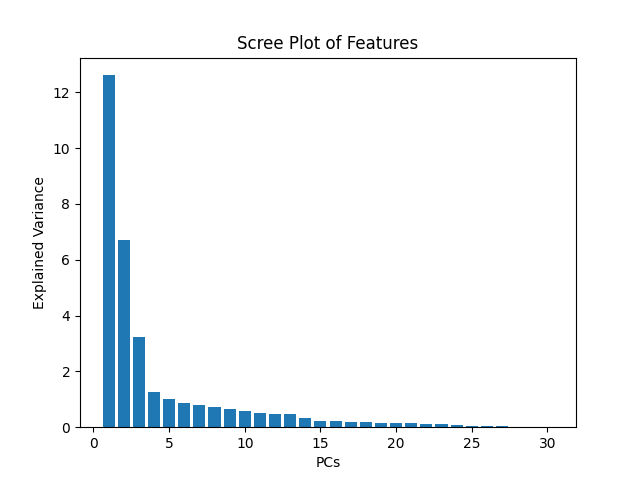

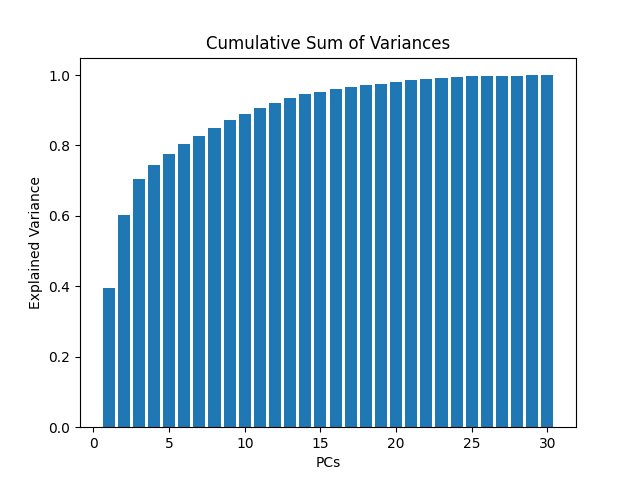

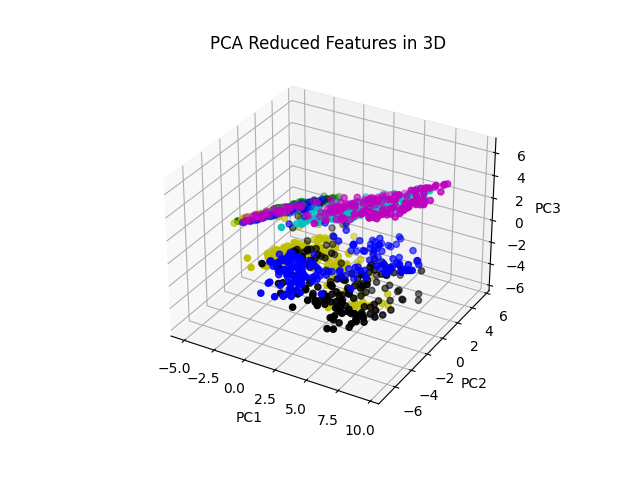

In [10]:
%matplotlib widget

from sklearn.decomposition import PCA
# PCA of exctracted features (Variance doesn't drop too slowly here, not so correlated)
pca = PCA(n_components=30) # So we can get scree plot of first 30 dims 
pca = pca.fit(df_new.iloc[:,:-1]) # PCA of all columns except class column
fig = plt.figure()
plt.bar(list(range(1,31)), pca.explained_variance_) # scree plot
plt.xlabel('PCs')
plt.ylabel('Explained Variance')
plt.title('Scree Plot of Features')
plt.show()
fig = plt.figure()
plt.bar(list(range(1,31)), np.cumsum(pca.explained_variance_ratio_)) # scree plot
plt.xlabel('PCs')
plt.ylabel('Explained Variance')
plt.title('Cumulative Sum of Variances')
plt.show()
# 3D scatter plot of first 3 PCs
pca2 = PCA(n_components=3) # So we can get scree plot of first 30 dims 
data3d = pca2.fit_transform(df_new.iloc[:,:-1])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b', 'y', 'm', 'c', 'k']
for idx in range(1,7): # for each label except no action
    plot_data = data3d[df_new['class']==idx, :]
    ax.scatter(plot_data[:,0],plot_data[:,1],plot_data[:,2], c=colors[idx])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA Reduced Features in 3D')
plt.show()

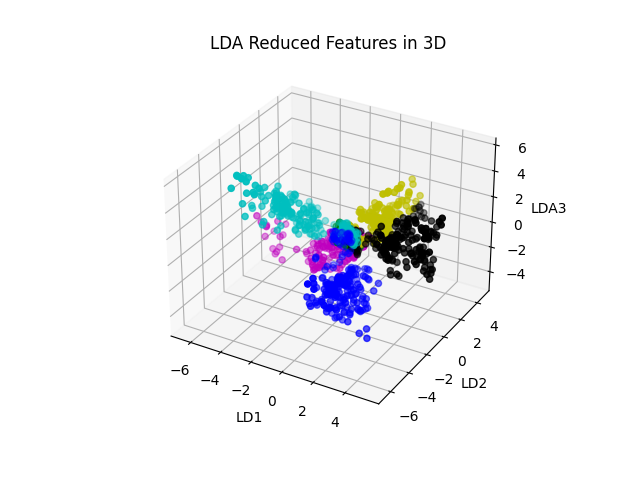

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# LDA analysis, followed by LDA classification predictions
model = LinearDiscriminantAnalysis(n_components=3)
model = model.fit(df_new.iloc[:,:-1], df_new['class'])
data3d = model.transform(df_new.iloc[:,:-1]) # LDA projection into most separable 3 dimensions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b', 'y', 'm', 'c', 'k']
actions = ['unmarked', 'rest', 'fist', 'wrist-flexion', 'wrist-extension', 'radial-deviations', 'ulnar-deviations', 'extended-palm']
for idx in range(1,7): # for each label except no action
    plot_data = data3d[df_new['class']==idx, :]
    ax.scatter(plot_data[:,0],plot_data[:,1],plot_data[:,2], c=colors[idx])
ax.set_xlabel('LD1')
ax.set_ylabel('LD2')
ax.set_zlabel('LDA3')
ax.set_title('LDA Reduced Features in 3D')
ax.set_label(actions[1:-1])
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# LDA Classification Predictions
model = LinearDiscriminantAnalysis()
X_train, X_test, y_train, y_test = train_test_split(df_new.iloc[:,:-1], df_new['class'], test_size=0.33, random_state=42)
model = model.fit(X_train, y_train)
y_train_pred, y_test_pred = model.predict(X_train), model.predict(X_test)
print('Training Accuracy:')
print(classification_report(y_train, y_train_pred))
print('Testing Accuracy:')
print(classification_report(y_test, y_test_pred))

Training Accuracy:
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.82      1736
         1.0       0.36      0.18      0.24       150
         2.0       0.59      0.77      0.67       135
         3.0       0.61      0.49      0.54       162
         4.0       0.67      0.65      0.66       150
         5.0       0.72      0.64      0.68       142
         6.0       0.81      0.71      0.75       161

    accuracy                           0.75      2636
   macro avg       0.65      0.61      0.62      2636
weighted avg       0.74      0.75      0.74      2636

Testing Accuracy:
              precision    recall  f1-score   support

         0.0       0.75      0.81      0.78       829
         1.0       0.43      0.19      0.26        86
         2.0       0.57      0.68      0.62        85
         3.0       0.63      0.49      0.55        77
         4.0       0.51      0.62      0.56        66
         5.0       0.69      0.51      0.